In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import math
import seaborn as sns
sns.set_style("whitegrid")

## Remaining Data Cleaning
Having already scraped the box office data into a csv file, we will load it and do any remaining data cleaning necessary.

In [2]:
rawNewBoxOffice = pd.read_csv("./cleandata/1977-2025_leap_really_clean.txt", sep='\t')
rawNewBoxOffice = rawNewBoxOffice.rename(columns={'Gross ($)': 'Weekly', 'Theater Number': 'Theaters'})
rawNewBoxOffice.head()

,Movie Title,Rank,Weekly,Theaters,Change in Theater Number,Gross to Date,Date
0,Saturday Night Fever (1977)-rl2926544385,1,8506454,504.0,NaN,8506454.0,1977-12-16
1,Saturday Night Fever (1977)-rl2926544385,1,7750444,726.0,222.0,16256898.0,1977-12-23
2,Saturday Night Fever (1977)-rl2926544385,1,6922844,726.0,NaN,23179742.0,1977-12-30
3,Star Wars: Episode IV - A New Hope (1977)-rl27...,1,493774,32.0,NaN,493774.0,1977-05-20
4,Star Wars: Episode IV - A New Hope (1977)-rl27...,1,2062644,43.0,11.0,2556418.0,1977-05-27


Assembling a dicitonary of dataframes with weekly gross data. We will add columns which compute the Week numbers in a movie's run as well as the "Per Screen Average" of 
$ \frac{\text{Number of Movies}}{\text{Number of Theaters}} $ for each week.

In [3]:
newBoxOffice ={}
for rawMovieTitle in rawNewBoxOffice['Movie Title'].unique():
    movieTitle = "-".join(rawMovieTitle.split('-')[:-1])
    newBoxOffice[movieTitle] = rawNewBoxOffice[rawNewBoxOffice['Movie Title'] == rawMovieTitle]
    dates = list(newBoxOffice[movieTitle].Date)
    xdata = [1]
    # Producing a "Week Column for movie data"
    for j in range(1,len(dates)):
        xdata += [int((datetime.strptime(dates[j],'%Y-%m-%d')-datetime.strptime(dates[j-1],'%Y-%m-%d')).days/7)+xdata[j-1]]
    newBoxOffice[movieTitle].insert(1, "Week", xdata)
    newBoxOffice[movieTitle].insert(5, "Avg", newBoxOffice[movieTitle]['Weekly']/newBoxOffice[movieTitle]['Theaters'])
    newBoxOffice[movieTitle] = newBoxOffice[movieTitle].set_index('Week')
    newBoxOffice[movieTitle].insert(1, "Week", xdata)

Below we are restricting our analysis to movies which have number of theater data, which start at the 1st week of it's run (some movie's have incomplete reporting), and excluding movies which played in theaters fewer than 3 weeks (often extremely low-budget movies). These restrictions will be necessary due to how we define the multiplier.

In [4]:
# boxOffice = pickle.load( open( "BoxOfficeMojoWeekly.p", "rb" ) )
boxOffice = newBoxOffice
# rawBoxOffice = pickle.load( open( "BoxOfficeMojoWeekly.p", "rb" ) )
titles = list(boxOffice.keys())
stringVal = False
badOrder = 0
for title in titles:
    movieData = boxOffice[title]
    # Remove entries with no weekly gross data, number of theaters, or with fewer than three reported weeks
    if ('Weekly' not in movieData.columns) or ('-' in movieData.Theaters.values) or (True in pd.isna(movieData.Theaters.values)) or (int(max(movieData.Week))<=3) or (movieData.Week.iloc[0]!=1):
        del boxOffice[title]
    # A few movies have special opening weekends which open very small. I've excluded them
    elif (type(movieData.Week.values[0])==str):
        print(title)
        del boxOffice[title]

In [5]:
# pickle.dump( boxOffice, open( "LeapReallyCleanedBoxofficeData.p", "wb" ) )
print("Total Movies Usable:", len(boxOffice))

Total Movies Usable: 6150


## Example Movie Performance Over Time
Here are some randomly selected movies and how they faired over time. I've included both raw grosses and the number of theaters the movies played in each week. The latter provides an idea how much of a movie's performance is due to availability vs. actual interest by the movie-going public.

C:\Users\viper\AppData\Local\Temp\ipykernel_13420\2751663187.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_13420\2751663187.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_13420\2751663187.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_13420\2751663187.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

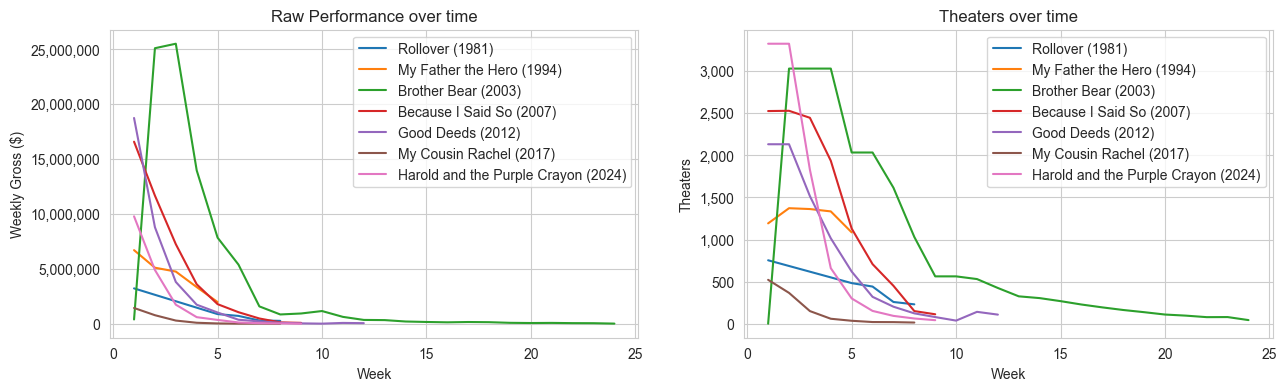

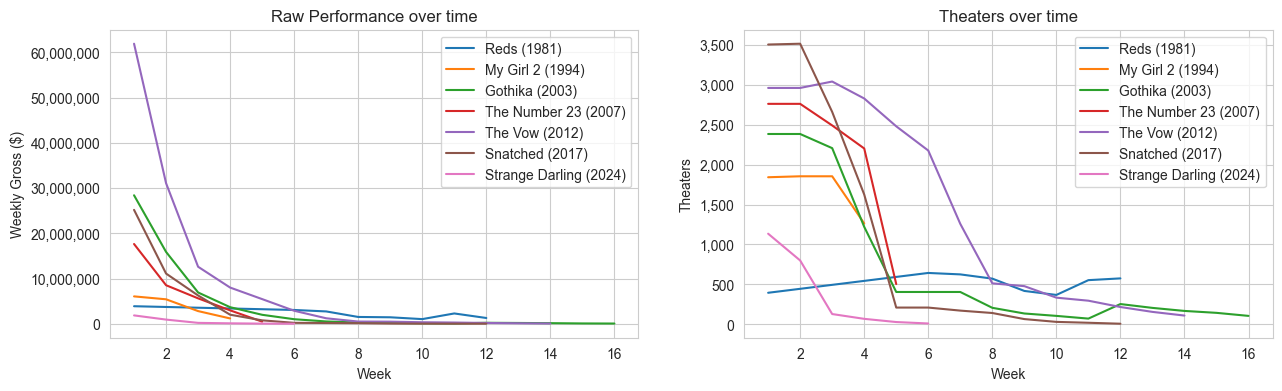

In [6]:
start = 11
for start in range(start, start+2, 1):
    figs, axs = plt.subplots(1, 2, figsize = (15,4))
    for title in list(boxOffice)[start::1000]:
        axs[1].plot(boxOffice[title].Week, boxOffice[title].Theaters, label=title)
        axs[0].plot(boxOffice[title].Week, boxOffice[title].Weekly, label=title)
    for i in range(2):  
        axs[i].set_xlabel('Week')
        axs[i].legend()
        axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
    axs[1].set_title('Theaters over time')
    axs[0].set_title('Raw Performance over time')
    axs[1].set_ylabel('Theaters')
    axs[0].set_ylabel('Weekly Gross ($)')

Already we can see from the plots a couple of notable types of movie lifetime gross trajectories. Most of the movies follow a typical pattern. Opening wide (in many theaters [often, as wide as it will ever open]) and then slowly grossing less and less whille being gradually pulled from theaters. You can also see with the example of Brother Bear (2003) in the first plots that some movies open very small. This is often because it is only open in a few theaters or even one theater for an exclusive premier before going to a wide release. Obviously this will effect our calculation of the multiplier since if we defined our opening to be only the first week Brother Bear would have an extremely high multiplier value which is not really indicative of its's long-term performance. By contrast, you can see the movie Reds in the bottom plot which was well-received critically and went on to receive many nominations at the Oscars. It opened relatively small, but played consistenly without much of a drop off. 

# The Box Office Multiplier
The concept of a box office "multiplier" is a way to quantify a movie's performance over time using a simple point estimate (see https://www.the-numbers.com/glossary). As you can see from the above plots, typically movies earn much of their gross in the first week (or weekend) of performance. The multiplier is calculated as follows
$$ 
 \text{Multiplier} = \frac{\text{Total Gross}}{\text{Opening}}
$$
It has the nice property that it is relatively independent of a movie's size (i.e. indie movie vs studio blockbuster with lots of marketing) since it benchmarks a movie's performance against itself. It is often used as a measure of a movie's "word-of-mouth" indicating that people who saw the movies told their friends to go see it. It is also, of course, directly proportional to a movie's total gross for a given opening so it is a sort of proxy for how much money a movie ultimately makes.
$$
\text{Total Gross} = (\text{Multiplier})(\text{Opening})
$$
We aim to study how well this metric correlates with "early" movie reviews with "early" meaning reviews that came out during or before a movie's "opening week", which we will define on a per-movie basis using the following analysis.

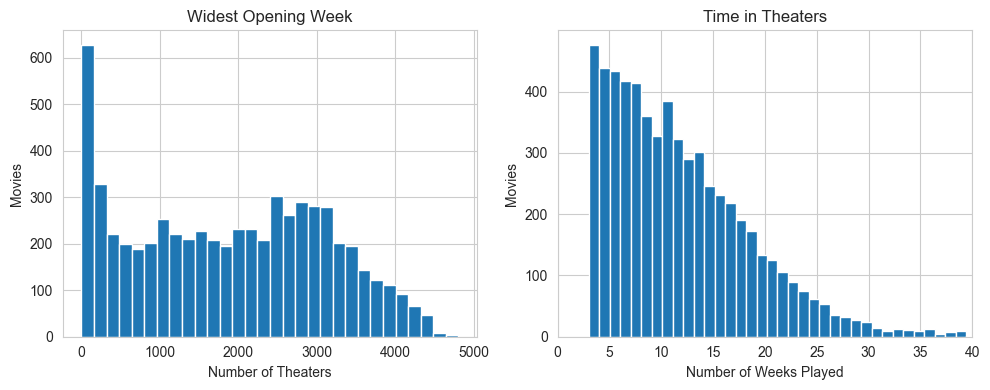

In [7]:
maxTheaters = []
numWeeks = []
for title in boxOffice.keys():
    maxTheaters.append(max(boxOffice[title].Theaters))
    numWeeks.append(int(max(boxOffice[title].Week)))

figs, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].hist(maxTheaters, bins=30)
axs[0].set_title('Widest Opening Week')
axs[0].set_xlabel('Number of Theaters')
axs[0].set_ylabel('Movies')

axs[1].hist(numWeeks, bins=np.linspace(0, 100, 100))
axs[1].set_title('Time in Theaters')
axs[1].set_xlim([0, 40])
axs[1].set_xlabel('Number of Weeks Played')
axs[1].set_ylabel('Movies')
figs.tight_layout()

# Computing the "multiplier" (Naïvely)
This quantifies how much of a movie's total gross comes from it's first initial run. Here I am naively computing it as the total gross divided by the gross from the first N weeks in theates. Thus, movies with longer "leg"s have higher multipliers meaning they made a significant portion of their total after the initial run. We theorize these higher multipliers will correlate with good reviews

Text(0.5, 0.98, 'Multiplier distribution for openings of various lengths')

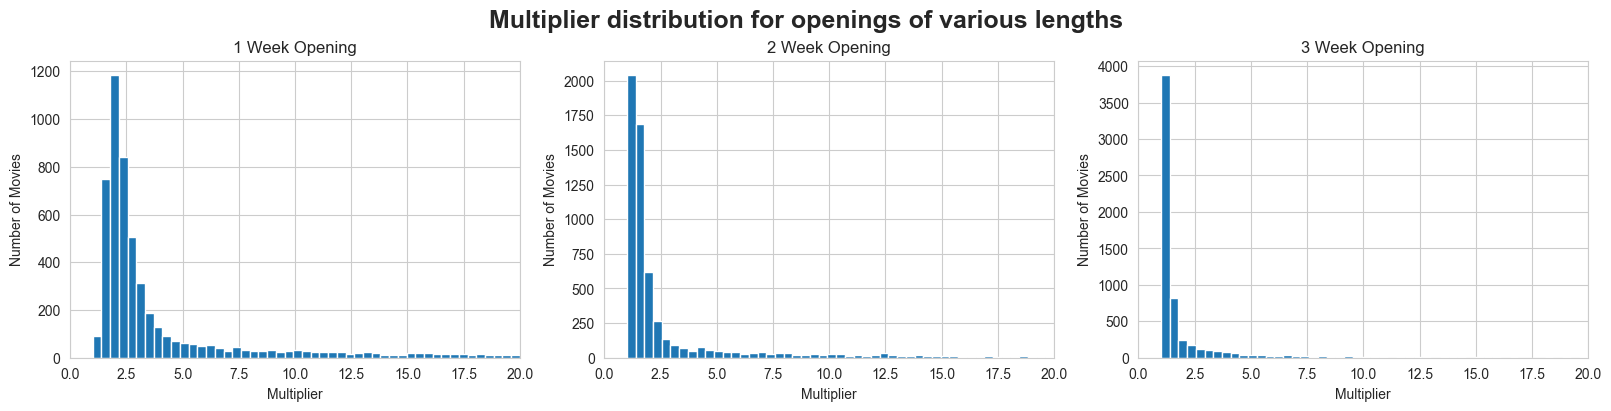

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), layout='constrained')
multipliers = [{}, {}, {}]
i=0
for weekThreshold in range(1, 4):
    multipliers[i] = boxOffice.copy()
    for title in boxOffice:
        opening = sum(boxOffice[title].Weekly.iloc[0:weekThreshold].values)
        total = sum(boxOffice[title].Weekly.values)
        multiplier = total/opening
        # if multiplier>5:
        #     print(title)
        #     print(multiplier)
        multipliers[i][title] = multiplier

    axs[i].hist(multipliers[weekThreshold-1].values(), bins=np.linspace(1, 20, 50))
    axs[i].set_xlim([0, 20])
    axs[i].set_title(str(weekThreshold)+" Week Opening")
    axs[i].set_xlabel("Multiplier")
    axs[i].set_ylabel("Number of Movies")
    i+=1
fig.suptitle("Multiplier distribution for openings of various lengths", fontsize=18, fontweight="bold")

# Computing the multiplier (Intelligently?)

Now let's try and take into account the fact that some movies open in only a few theaters to start with and are thus guaranteed to have small "openings". Thus we will attempt to define the opening week as the cumulative total from the initial weeks up to the first week in which it was open in a number of theaters greater than a certain fraction of the widest week (week it played in the most theaters)

Text(0.5, 0.98, 'Multiplier distribution for openings of various relative widths')

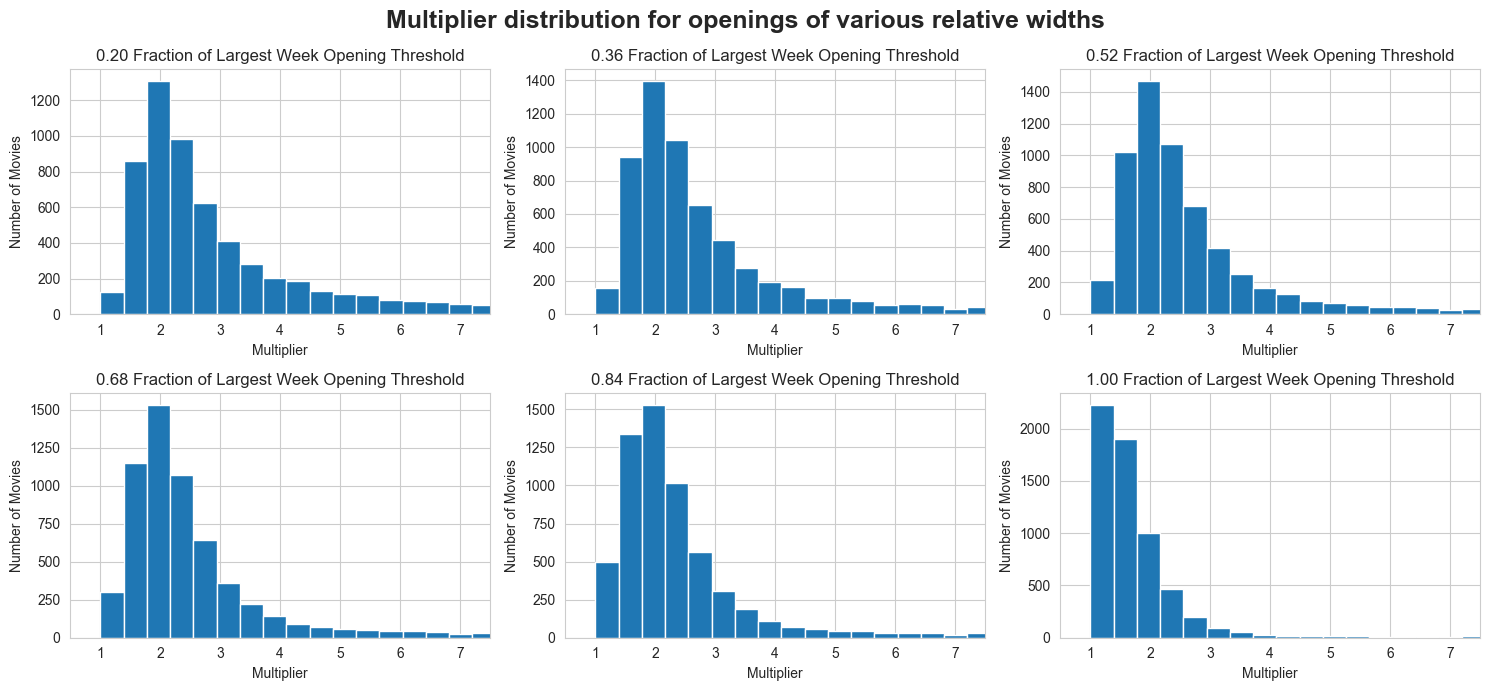

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(15,7), layout='tight')
i=0
for threshold in np.linspace(0.2, 1, 6):
    smartMultipliers = {}
    for title in boxOffice:
        widestWeek = max(boxOffice[title].Theaters)
        startingWeek = 0
        currentWeek = 0
        for week in boxOffice[title].Theaters>=threshold*widestWeek:
            if week:
                startingWeek = currentWeek+1
                break
            currentWeek+=1
        opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
        total = sum(boxOffice[title].Weekly.values)
        multiplier = total/opening
        smartMultipliers[title] = multiplier
    axs[i//3, i%3].hist(smartMultipliers.values(), bins=np.linspace(1, 20, 50))
    axs[i//3, i%3].set_xlim([0.5, 7.5])
    axs[i//3, i%3].set_title('%.2f Fraction of Largest Week Opening Threshold' %threshold)
    axs[i//3, i%3].set_xlabel("Multiplier")
    axs[i//3, i%3].set_ylabel("Number of Movies")
    # axs[i//3, i%3].set_yscale('log')
    i+=1
fig.suptitle("Multiplier distribution for openings of various relative widths", fontsize=18, fontweight="bold")

It seems like setting the opening threshold high does lower the number of high multiplier outliers, but the vast majority still fit follow a pretty predictable distribution peaking around 2. I think there are a sensible range of theshold values you could choose in between 0.4 and 0.8 with a trade off of giving certain exclusive premiere movies abnormally high multipliers or artificially lowering movie's multipliers which gradually expanded due to a genuine increase in demand. Let's look at some outlier movies with high multipliers from this metric just for fun. 
##### I will set the "Opening" threshold to be 60% of the widest week in terms of number of theaters

# Some outliers with high multipliers

C:\Users\viper\AppData\Local\Temp\ipykernel_13420\2535157818.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_13420\2535157818.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_13420\2535157818.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
C:\Users\viper\AppData\Local\Temp\ipykernel_13420\2535157818.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

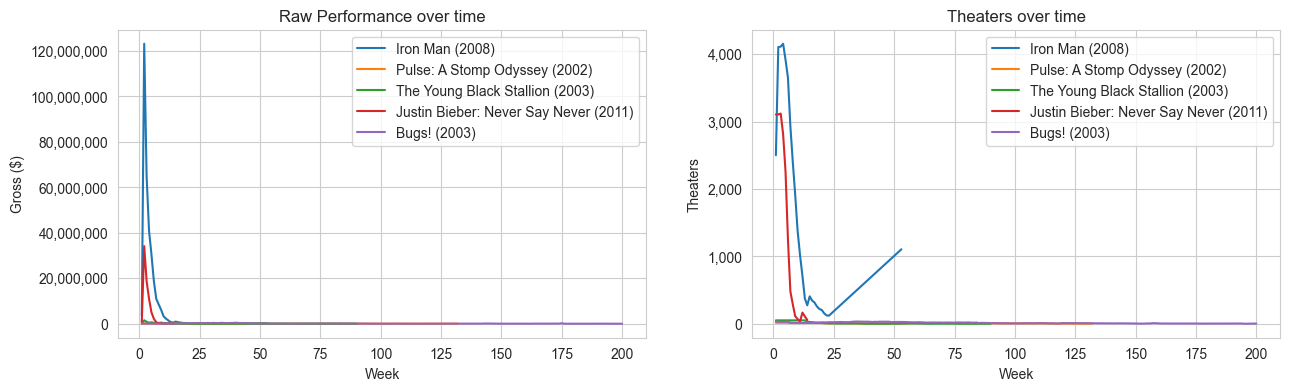

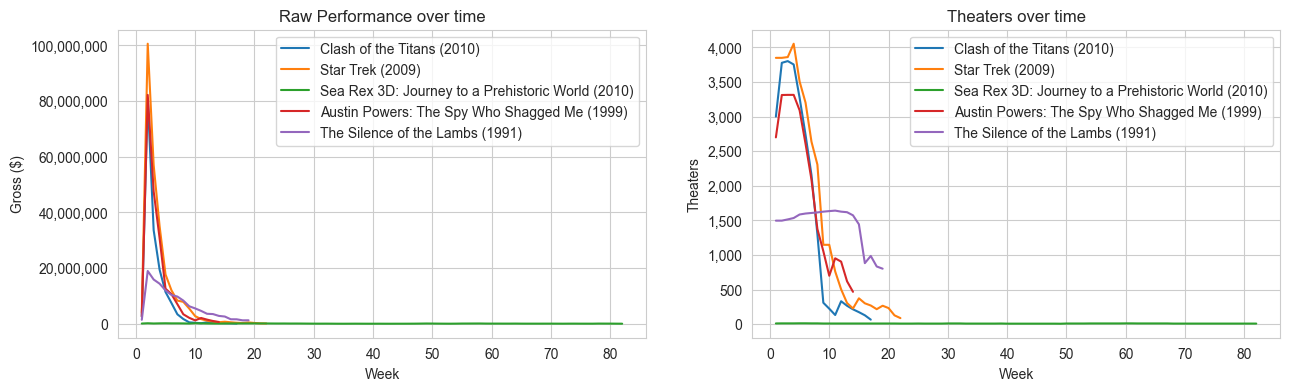

In [10]:
finalMultiplier = {}
finalthreshold = 0.6
for title in boxOffice:
    widestWeek = max(boxOffice[title].Theaters)
    startingWeek = 0
    currentWeek = 0
    for week in boxOffice[title].Theaters>=finalthreshold*widestWeek:
        if week:
            startingWeek = currentWeek+1
            break
        currentWeek+=1
    opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
    total = sum(boxOffice[title].Weekly.values)
    multiplier = total/opening
    finalMultiplier[title] = multiplier
sortedMultipliers = dict(sorted(finalMultiplier.items(), key=lambda item: item[1]))
list(sortedMultipliers.keys())[-10:-5]
start = 1
for set in range(0, 2, 1):
    figs, axs = plt.subplots(1, 2, figsize = (15,4))
    for title in list(sortedMultipliers.keys())[-5*set-6:-set*5-1]:
        axs[1].plot(boxOffice[title].Week, boxOffice[title].Theaters, label=title)
        axs[0].plot(boxOffice[title].Week, boxOffice[title].Weekly, label=title)
    for i in range(2):  
        axs[i].set_xlabel('Week')
        axs[i].legend()
        axs[i].set_yticklabels(['{:,}'.format(int(x)) for x in axs[i].get_yticks().tolist()])
    axs[1].set_title('Theaters over time')
    axs[0].set_title('Raw Performance over time')
    axs[1].set_ylabel('Theaters')
    axs[0].set_ylabel('Gross ($)')